In [1]:
# %matplotlib inline
# %matplotlib notebook
from dataGen import Gen
from multiscale_vae import vae
from train import slidingWindow, criterion, train, test

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt

/home/kadran1/mambaforge/envs/testenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# all parameters for generating the time series should be configured in this cell
time = 1200
step = 0.2
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "number":0,
        "max_gain":5        
        },
    "Trend": {
        "number":2,
        "max_slope":0.1
        },
    "Seasonality": {
        "number":3,
        "frequency_range":(1, 5),
        "amplitude_range":(5, 15),
        }
    }

### Init Model
latent_dims = 8
L = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v = vae(n_channels, L, latent_dims)
opt = optim.Adam(v.parameters(), lr = 0.001)

{'T': 6000, 'nchannels': 3, 'mu': array([18, 61, 51]), 'cov': array([[0.1365237 , 0.        , 0.        ],
       [0.        , 0.38426994, 0.        ],
       [0.        , 0.        , 0.70749189]])}
{'Pulse': {'channel': [], 'index': [], 'scale': []}, 'Trend': {'channel': [1, 1], 'index': [182, 638], 'slope': [0.014120272855801003, -0.046012727893449124]}, 'Seasonality': {'channel': [1, 1, 2], 'frequency': [1.7539343996018664, 3.5228018549606763, 2.290007917203362], 'amplitude': [6, 8, 9], 'phaseshift': [144, 120, 75]}}


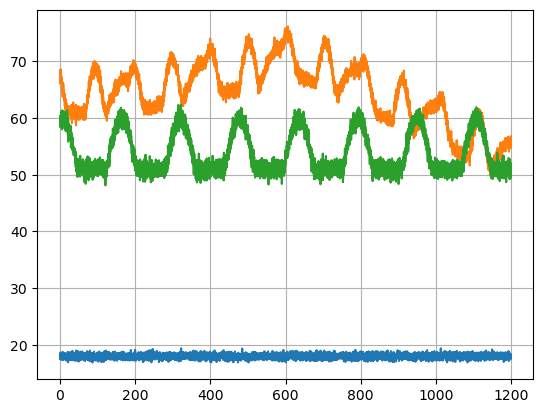

In [7]:
X = Gen(time, step, val, n_channels, effects)
x, params, e_params = X.parameters()
print(params)
print(e_params)
X.show()

In [8]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

# train_set = slidingWindow(train, 30)
# val_set = slidingWindow(val, 30)
# test_set = slidingWindow(test, 30)

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=2,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=2,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=2,
                        shuffle = False
                        )

In [9]:
for epoch in range(1, 50):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/4700 (0%)]	Loss: 8384.426758
Train Epoch: 1 [200/4700 (4%)]	Loss: 515.680054
Train Epoch: 1 [400/4700 (9%)]	Loss: 1088.343384
Train Epoch: 1 [600/4700 (13%)]	Loss: 375.672424
Train Epoch: 1 [800/4700 (17%)]	Loss: 946.273193
Train Epoch: 1 [1000/4700 (21%)]	Loss: 715.133057
Train Epoch: 1 [1200/4700 (26%)]	Loss: 566.929077
Train Epoch: 1 [1400/4700 (30%)]	Loss: 1441.105713
Train Epoch: 1 [1600/4700 (34%)]	Loss: 430.949951
Train Epoch: 1 [1800/4700 (38%)]	Loss: 672.148376
Train Epoch: 1 [2000/4700 (43%)]	Loss: 210.384216
Train Epoch: 1 [2200/4700 (47%)]	Loss: 279.318481
Train Epoch: 1 [2400/4700 (51%)]	Loss: 170.271698
Train Epoch: 1 [2600/4700 (55%)]	Loss: 912.582153
Train Epoch: 1 [2800/4700 (60%)]	Loss: 182.091934
Train Epoch: 1 [3000/4700 (64%)]	Loss: 523.602966
Train Epoch: 1 [3200/4700 (68%)]	Loss: 152.857971
Train Epoch: 1 [3400/4700 (72%)]	Loss: 116.623199
Train Epoch: 1 [3600/4700 (77%)]	Loss: 171.396347
Train Epoch: 1 [3800/4700 (81%)]	Loss: 100.566498
Train E

Train Epoch: 7 [4000/4700 (85%)]	Loss: 1.091874
Train Epoch: 7 [4200/4700 (89%)]	Loss: 2.331585
Train Epoch: 7 [4400/4700 (94%)]	Loss: 2.504797
Train Epoch: 7 [4600/4700 (98%)]	Loss: 10.294995
====> Epoch: 7 Average loss: 6.0463
Train Epoch: 8 [0/4700 (0%)]	Loss: 67.606529
Train Epoch: 8 [200/4700 (4%)]	Loss: 4.582639
Train Epoch: 8 [400/4700 (9%)]	Loss: 3.193389
Train Epoch: 8 [600/4700 (13%)]	Loss: 2.342562
Train Epoch: 8 [800/4700 (17%)]	Loss: 5.442117
Train Epoch: 8 [1000/4700 (21%)]	Loss: 5.314235
Train Epoch: 8 [1200/4700 (26%)]	Loss: 2.646185
Train Epoch: 8 [1400/4700 (30%)]	Loss: 4.397014
Train Epoch: 8 [1600/4700 (34%)]	Loss: 1.279021
Train Epoch: 8 [1800/4700 (38%)]	Loss: 5.630514
Train Epoch: 8 [2000/4700 (43%)]	Loss: 3.394440
Train Epoch: 8 [2200/4700 (47%)]	Loss: 2.089808
Train Epoch: 8 [2400/4700 (51%)]	Loss: 6.847172
Train Epoch: 8 [2600/4700 (55%)]	Loss: 5.524176
Train Epoch: 8 [2800/4700 (60%)]	Loss: 0.709377
Train Epoch: 8 [3000/4700 (64%)]	Loss: 2.660874
Train Epoch:

Train Epoch: 14 [3400/4700 (72%)]	Loss: 0.437607
Train Epoch: 14 [3600/4700 (77%)]	Loss: 2.224597
Train Epoch: 14 [3800/4700 (81%)]	Loss: 1.787544
Train Epoch: 14 [4000/4700 (85%)]	Loss: 1.207668
Train Epoch: 14 [4200/4700 (89%)]	Loss: 2.530369
Train Epoch: 14 [4400/4700 (94%)]	Loss: 0.837033
Train Epoch: 14 [4600/4700 (98%)]	Loss: 7.460299
====> Epoch: 14 Average loss: 2.9378
Train Epoch: 15 [0/4700 (0%)]	Loss: 70.944878
Train Epoch: 15 [200/4700 (4%)]	Loss: 3.166167
Train Epoch: 15 [400/4700 (9%)]	Loss: 1.806593
Train Epoch: 15 [600/4700 (13%)]	Loss: 2.147213
Train Epoch: 15 [800/4700 (17%)]	Loss: 1.127111
Train Epoch: 15 [1000/4700 (21%)]	Loss: 2.644901
Train Epoch: 15 [1200/4700 (26%)]	Loss: 2.645895
Train Epoch: 15 [1400/4700 (30%)]	Loss: 5.429522
Train Epoch: 15 [1600/4700 (34%)]	Loss: 1.528525
Train Epoch: 15 [1800/4700 (38%)]	Loss: 3.709721
Train Epoch: 15 [2000/4700 (43%)]	Loss: 1.172366
Train Epoch: 15 [2200/4700 (47%)]	Loss: 2.274277
Train Epoch: 15 [2400/4700 (51%)]	Loss: 8

Train Epoch: 21 [2600/4700 (55%)]	Loss: 1.456595
Train Epoch: 21 [2800/4700 (60%)]	Loss: 0.748185
Train Epoch: 21 [3000/4700 (64%)]	Loss: 1.321215
Train Epoch: 21 [3200/4700 (68%)]	Loss: 1.527617
Train Epoch: 21 [3400/4700 (72%)]	Loss: 1.167716
Train Epoch: 21 [3600/4700 (77%)]	Loss: 1.415615
Train Epoch: 21 [3800/4700 (81%)]	Loss: 2.616823
Train Epoch: 21 [4000/4700 (85%)]	Loss: 1.939963
Train Epoch: 21 [4200/4700 (89%)]	Loss: 1.858575
Train Epoch: 21 [4400/4700 (94%)]	Loss: 1.598869
Train Epoch: 21 [4600/4700 (98%)]	Loss: 6.073666
====> Epoch: 21 Average loss: 2.9682
Train Epoch: 22 [0/4700 (0%)]	Loss: 64.611282
Train Epoch: 22 [200/4700 (4%)]	Loss: 3.046911
Train Epoch: 22 [400/4700 (9%)]	Loss: 4.059156
Train Epoch: 22 [600/4700 (13%)]	Loss: 3.092675
Train Epoch: 22 [800/4700 (17%)]	Loss: 0.652725
Train Epoch: 22 [1000/4700 (21%)]	Loss: 2.967958
Train Epoch: 22 [1200/4700 (26%)]	Loss: 3.240282
Train Epoch: 22 [1400/4700 (30%)]	Loss: 3.197122
Train Epoch: 22 [1600/4700 (34%)]	Loss: 2

Train Epoch: 28 [1800/4700 (38%)]	Loss: 5.712169
Train Epoch: 28 [2000/4700 (43%)]	Loss: 1.738376
Train Epoch: 28 [2200/4700 (47%)]	Loss: 0.379895
Train Epoch: 28 [2400/4700 (51%)]	Loss: 9.120916
Train Epoch: 28 [2600/4700 (55%)]	Loss: 1.882007
Train Epoch: 28 [2800/4700 (60%)]	Loss: 0.652932
Train Epoch: 28 [3000/4700 (64%)]	Loss: 0.627994
Train Epoch: 28 [3200/4700 (68%)]	Loss: 1.663486
Train Epoch: 28 [3400/4700 (72%)]	Loss: 1.205656
Train Epoch: 28 [3600/4700 (77%)]	Loss: 1.841830
Train Epoch: 28 [3800/4700 (81%)]	Loss: 2.004370
Train Epoch: 28 [4000/4700 (85%)]	Loss: 1.715063
Train Epoch: 28 [4200/4700 (89%)]	Loss: 1.638884
Train Epoch: 28 [4400/4700 (94%)]	Loss: 1.120687
Train Epoch: 28 [4600/4700 (98%)]	Loss: 6.741324
====> Epoch: 28 Average loss: 3.0191
Train Epoch: 29 [0/4700 (0%)]	Loss: 72.635071
Train Epoch: 29 [200/4700 (4%)]	Loss: 3.183280
Train Epoch: 29 [400/4700 (9%)]	Loss: 3.861250
Train Epoch: 29 [600/4700 (13%)]	Loss: 1.989819
Train Epoch: 29 [800/4700 (17%)]	Loss: 0

Train Epoch: 35 [1000/4700 (21%)]	Loss: 3.019891
Train Epoch: 35 [1200/4700 (26%)]	Loss: 2.724436
Train Epoch: 35 [1400/4700 (30%)]	Loss: 5.900308
Train Epoch: 35 [1600/4700 (34%)]	Loss: 1.585781
Train Epoch: 35 [1800/4700 (38%)]	Loss: 4.096360
Train Epoch: 35 [2000/4700 (43%)]	Loss: 2.127522
Train Epoch: 35 [2200/4700 (47%)]	Loss: 1.482880
Train Epoch: 35 [2400/4700 (51%)]	Loss: 7.529942
Train Epoch: 35 [2600/4700 (55%)]	Loss: 2.592902
Train Epoch: 35 [2800/4700 (60%)]	Loss: 0.494424
Train Epoch: 35 [3000/4700 (64%)]	Loss: 0.418233
Train Epoch: 35 [3200/4700 (68%)]	Loss: 1.593042
Train Epoch: 35 [3400/4700 (72%)]	Loss: 1.345655
Train Epoch: 35 [3600/4700 (77%)]	Loss: 1.822290
Train Epoch: 35 [3800/4700 (81%)]	Loss: 2.594215
Train Epoch: 35 [4000/4700 (85%)]	Loss: 1.724446
Train Epoch: 35 [4200/4700 (89%)]	Loss: 2.421993
Train Epoch: 35 [4400/4700 (94%)]	Loss: 0.736783
Train Epoch: 35 [4600/4700 (98%)]	Loss: 6.910095
====> Epoch: 35 Average loss: 3.0338
Train Epoch: 36 [0/4700 (0%)]	Lo

Train Epoch: 42 [200/4700 (4%)]	Loss: 2.625911
Train Epoch: 42 [400/4700 (9%)]	Loss: 5.082986
Train Epoch: 42 [600/4700 (13%)]	Loss: 1.964217
Train Epoch: 42 [800/4700 (17%)]	Loss: 1.565882
Train Epoch: 42 [1000/4700 (21%)]	Loss: 3.430560
Train Epoch: 42 [1200/4700 (26%)]	Loss: 2.373402
Train Epoch: 42 [1400/4700 (30%)]	Loss: 5.196051
Train Epoch: 42 [1600/4700 (34%)]	Loss: 1.247997
Train Epoch: 42 [1800/4700 (38%)]	Loss: 4.844650
Train Epoch: 42 [2000/4700 (43%)]	Loss: 1.746684
Train Epoch: 42 [2200/4700 (47%)]	Loss: 4.953822
Train Epoch: 42 [2400/4700 (51%)]	Loss: 8.789741
Train Epoch: 42 [2600/4700 (55%)]	Loss: 1.705284
Train Epoch: 42 [2800/4700 (60%)]	Loss: 0.713720
Train Epoch: 42 [3000/4700 (64%)]	Loss: 0.755205
Train Epoch: 42 [3200/4700 (68%)]	Loss: 1.957103
Train Epoch: 42 [3400/4700 (72%)]	Loss: 0.555560
Train Epoch: 42 [3600/4700 (77%)]	Loss: 1.383384
Train Epoch: 42 [3800/4700 (81%)]	Loss: 4.545336
Train Epoch: 42 [4000/4700 (85%)]	Loss: 1.583289
Train Epoch: 42 [4200/4700

Train Epoch: 48 [4200/4700 (89%)]	Loss: 2.353744
Train Epoch: 48 [4400/4700 (94%)]	Loss: 0.542463
Train Epoch: 48 [4600/4700 (98%)]	Loss: 7.274279
====> Epoch: 48 Average loss: 3.1123
Train Epoch: 49 [0/4700 (0%)]	Loss: 58.177612
Train Epoch: 49 [200/4700 (4%)]	Loss: 2.635907
Train Epoch: 49 [400/4700 (9%)]	Loss: 5.506763
Train Epoch: 49 [600/4700 (13%)]	Loss: 2.589730
Train Epoch: 49 [800/4700 (17%)]	Loss: 0.934268
Train Epoch: 49 [1000/4700 (21%)]	Loss: 3.833490
Train Epoch: 49 [1200/4700 (26%)]	Loss: 2.651777
Train Epoch: 49 [1400/4700 (30%)]	Loss: 4.914106
Train Epoch: 49 [1600/4700 (34%)]	Loss: 1.325709
Train Epoch: 49 [1800/4700 (38%)]	Loss: 5.166338
Train Epoch: 49 [2000/4700 (43%)]	Loss: 2.211911
Train Epoch: 49 [2200/4700 (47%)]	Loss: 2.147839
Train Epoch: 49 [2400/4700 (51%)]	Loss: 7.913792
Train Epoch: 49 [2600/4700 (55%)]	Loss: 2.859343
Train Epoch: 49 [2800/4700 (60%)]	Loss: 0.560643
Train Epoch: 49 [3000/4700 (64%)]	Loss: 1.211655
Train Epoch: 49 [3200/4700 (68%)]	Loss: 1

(500, 3)


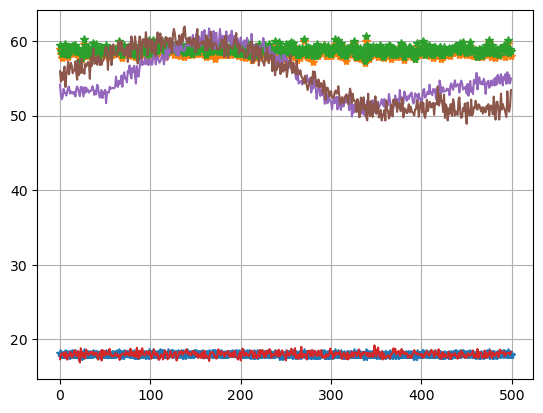

In [12]:
x_hat = np.array([])
# z_hat = np.array([])
# mu_hat = np.array([])
# var_hat = np.array([])
v.eval()
for i, data in enumerate(test_data):
    x_rec, mu, log = v(data)
    
    x_rec = x_rec.detach().numpy()

    if len(x_hat) == 0:
        x_hat = x_rec
    else:
        x_hat= np.append(x_hat, x_rec, axis= 0)
        
print(x_hat.shape)
plt.plot(x_hat, "*")
plt.plot(test_.T[:-L], "-")
plt.grid(True)

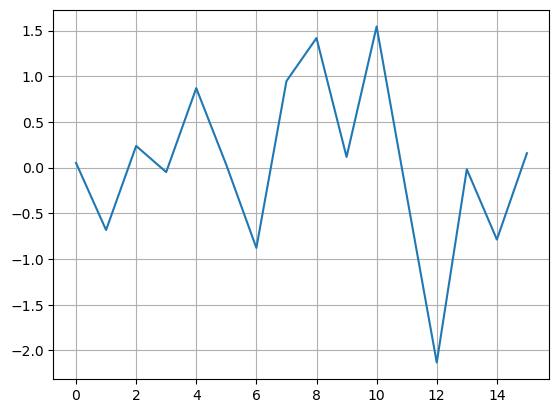

In [20]:
plt.plot(z_hat[-1])
plt.grid(True)

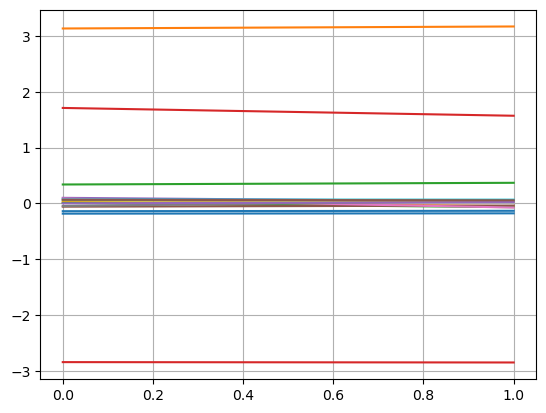

In [22]:
plt.plot(mu.detach())
plt.grid(True)

In [18]:
z_hat[-1].shape

(6,)

In [23]:
mu

tensor([[-1.8248e-01,  2.5828e-02,  8.1410e-03,  1.7095e+00,  1.0078e-01,
         -5.7696e-02,  8.6696e-02, -4.5474e-02,  5.1387e-02,  7.0977e-02,
         -1.3857e-01,  3.1315e+00,  3.3938e-01, -2.8398e+00,  1.5553e-03,
          6.6068e-02],
        [-1.7686e-01, -4.8422e-02, -6.6673e-02,  1.5698e+00,  3.6523e-02,
         -3.7630e-02, -7.3482e-02,  4.5211e-02,  4.3730e-02,  6.7609e-02,
         -1.3137e-01,  3.1674e+00,  3.6946e-01, -2.8462e+00,  2.5491e-02,
          5.6175e-02]], grad_fn=<CatBackward0>)

In [27]:
np.random.uniform(high=1, size=3)

array([0.33346796, 0.30842026, 0.10271011])

In [14]:
n = x.shape[1]
train = x[:, :int(0.8*n)]
val = x[:, int(0.8*n):int(0.9*n)]
test = x[:, int(0.9*n):]

In [15]:
train.shape

torch.Size([3, 40000])

In [16]:
val.shape

torch.Size([3, 5000])

In [8]:
len(test_data.dataset)

4970

In [18]:
:50

SyntaxError: invalid syntax (1706291904.py, line 1)